In [10]:
from tqdm.std import tqdm
import torch
import numpy as np
import transformer_lens as tl
import io, sys
from sentence_transformers import SentenceTransformer
import pandas as pd
from pathlib import Path
from IPython.display import Image, display
from functools import partial
import matplotlib.pyplot as plt
import time
import json
import contextlib
import random
import warnings
warnings.filterwarnings("ignore")

In [3]:
# %% [SETUP]

# Determine project root
ROOT = Path.cwd()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent

# Define and create results directory
RESULTS = ROOT / "results"
RESULTS.mkdir(exist_ok=True)

# Add src/ to PYTHONPATH so modules can be imported
sys.path.insert(0, str(ROOT / "src"))

# Set global seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Select device (CPU or CUDA)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---

# 1. UMAP + HDBSCAN Clustering

### For more theoretical insight and extended formulas, please see Chapter 1 of /notebooks/theory.ipynb

---

$\bullet$ In this section we first perform clustering on the columns of the decoder matrices for all 12 layers of gpt2-small (it seems **unsatisfactory**), and then we move on to clustering the embeddings of text descriptions of features (Neuronpedia) and study it carefully throughout the project further.

---

## Decoder Columns: Grid-Search Clustering (Layers 0–11)

This cell loops over each decoder layer (0–11) and performs:

1. **Embedding load**  
   - Load and L₂-normalize SAE decoder weights for current layer.

2. **UMAP reduction**  
   - Grid search over `n_neighbors` ∈ {10, 20}  
   - Fixed: `min_dist=0.1`, `n_components=15`, `metric='cosine'`

3. **HDBSCAN clustering**  
   - Grid search over `min_cluster_size` ∈ {8, 12, 20}  
   - Fixed: `metric='euclidean'`, `cluster_selection_method='eom'`

4. **Selection criterion**  
   - Choose the (n_neighbors, min_cluster_size) pair with highest **mean_coherence**  
   - **Fallback** to (10, 8) with all points as noise if no valid clusters found

5. **Outputs**  
   - **labels**: cluster assignments (`.npy`)  
   - **reduced**: UMAP embeddings (`.npy`)  
   - **metrics**: JSON summary including chosen hyperparameters and coherence score  

---

In [4]:
# %% [CLUSTER ALL LAYERS — decoder columns]

from clustering import run_decoder_layer_auto, save_decoder_results

for layer_idx in tqdm(
    range(12),
    desc="Decoder clustering",
    file=sys.stdout,
    ascii=True,
    ncols=80,
    dynamic_ncols=False,
    leave=True
):
    labels, red, metrics, k, mcs = run_decoder_layer_auto(layer_idx)
    save_decoder_results(layer_idx, labels, red, metrics, k, mcs)

Decoder L00: k=20, mcs=12 → mean_coherence=0.174, noise=0.873                   
✔ saved decoder layer 00 to results\clusters_all_layers\decoder_clusters\layer00_metrics.json
Decoder L01: k=10, mcs=8 → mean_coherence=0.305, noise=0.000                    
✔ saved decoder layer 01 to results\clusters_all_layers\decoder_clusters\layer01_metrics.json
Decoder L02: k=20, mcs=8 → mean_coherence=0.220, noise=0.670                    
✔ saved decoder layer 02 to results\clusters_all_layers\decoder_clusters\layer02_metrics.json
Decoder L03: k=20, mcs=8 → mean_coherence=0.224, noise=0.607                    
✔ saved decoder layer 03 to results\clusters_all_layers\decoder_clusters\layer03_metrics.json
Decoder L04: k=20, mcs=8 → mean_coherence=0.231, noise=0.645                    
✔ saved decoder layer 04 to results\clusters_all_layers\decoder_clusters\layer04_metrics.json
Decoder L05: k=10, mcs=8 → mean_coherence=0.295, noise=0.001                    
✔ saved decoder layer 05 to results\clusters

---

$\bullet$ Let's look at the **specific clusters** that were obtained by clustering *the columns of the decoder matrices*. Specifically, we want to look at the text descriptions of the features that fell into specific clusters.

---

In [45]:
from clustering import describe_decoder_cluster

describe_decoder_cluster(layer_idx=2, decoder_cluster_id=7)
print()
describe_decoder_cluster(layer_idx=10, decoder_cluster_id=14)

Layer 2, Decoder cluster 7, Items: 10
- blogs and blogging platforms
- word "bag" in varying contexts
- championship titles and achievements in sports
- logging in computer systems and programming contexts
- "rigidity" and its variations in context
- the name "Cox" and its variations
- logarithmic functions and logging processes
- data management and logging processes
- grammar and manuscript formatting
- rigidity, particularly in thought or structure

Layer 10, Decoder cluster 14, Items: 8
- specific dates, particularly in September and August
- individuals with the title "Jr." or "Sr." in their names
- measurements and weights
- dates and references to time-related events
- title "Mr." followed by a proper noun
- governmental authorities or officials
- doctors, specifically those labeled as "Dr." with varying levels of significance
- law enforcement and military personnel


---

**Decoder‐based Clustering Exhibits Low Semantic Coherence**

When we cluster the decoder‐weight columns, the resulting groups mix unrelated concepts:

- **Layer 2, Cluster 7 (10 items):** ranges from “blogs and blogging platforms” and the word “bag” to sports championship titles, computer logging, grammatical rigidity, the name “Cox,” and logarithmic functions — no unifying theme emerges.  
- **Layer 10, Cluster 14 (8 items):** blends specific dates, honorifics (“Jr.”/“Sr.”/“Mr.”), measurements and weights, doctors, officials, and military personnel — again, lacking a coherent semantic focus.

These examples confirm that clustering in decoder‐space produces semantically noisy clusters.  We therefore concentrate further on clustering the **text‐embedding** space, which yields far more interpretable and conceptually tight groupings. 

---

## Text-Embedding Clustering Pipeline (Layers 0–11)

- **Input & Preprocessing**  
  • Load raw JSON descriptions for each layer (0–11)  
  • Clean text via regex (`clean_text`), drop duplicates  

- **Embedding**  
  • Encode processed texts with `SentenceTransformer(cfg.model_name)`  
  • L₂-normalize embeddings  

- **Primary Clustering**  
  1. **UMAP** reduction:  
     - `n_neighbors` ∈ {10, 20}  
     - `min_dist=0.1`, `n_components=15`, `metric='cosine'`  
  2. **HDBSCAN**:  
     - `min_cluster_size` ∈ {8, 12, 20}  
     - `metric='euclidean'`, `cluster_selection_method='eom'`  
  • Select hyperparameter pair maximizing **mean_coherence**

- **Noise Refinement**  
  • Re-cluster points labeled as noise using UMAP (`n_neighbors` ∈ {5,10,15}; `min_dist=0.05`) + HDBSCAN (`min_cluster_size` ∈ {3,4,6})  
  • Merge any new clusters exceeding coherence threshold

- **Outputs**  
  • **CSV** (unique clusters & full labels) and **JSON** metrics → `cfg.out_dir`  
  • **.npy** label arrays → `cfg.labels_dir`  

In [4]:
# %% [CLUSTER ALL LAYERS — run clustering.py pipeline]

# CSV and JSON outputs go to cfg.out_dir
#   (default: project_root/results/clusters_all_layers)
# NumPy label arrays go to cfg.labels_dir
#   (default: project_root/results/labels)

from clustering import cfg, run_layer_auto, save_results
from sentence_transformers import SentenceTransformer

# Load a single SentenceTransformer model for all layers
st_model = SentenceTransformer(cfg.model_name, device=cfg.device)

# Iterate over layers 0…11 and run the two‑stage clustering pipeline
for layer_idx in tqdm(
    range(12),
    desc="Clustering layers",
    file=sys.stdout,          
    ascii=True,               
    ncols=80,                 
    dynamic_ncols=False,      
    leave=True                
):
    # 1) run primary + noise‑refinement clustering
    df_unique, df_full, labels_vec, metrics_primary, metrics_refined = run_layer_auto(
        layer_idx, st_model
    )
    save_results(
        layer_idx,
        df_unique,
        df_full,
        labels_vec,
        metrics_primary,
        metrics_refined
    )

                                                                                
=== Layer 00 ===
  • 30369 unique non-empty descriptions                                         
  • embeddings cached (layer00_emb_4e51c68c0a.npy)                              
  • primary: n_nb=20, mcs=8 → mean_coherence=0.556, noise=0.386, 612 clusters   
  • refine_noise: n_nb=10, mcs=3 → mean_coherence=0.580, noise=0.068, +1607 clusters
  • total: 2219 clusters, mean_coherence=0.580, noise=0.068 (2079/30369)        
✔ layer 00: unique=30369, full=32768, primary_mean_coherence=0.556, refined_mean_coherence=0.580
                                                                                
=== Layer 01 ===
  • 29946 unique non-empty descriptions                                         
  • embeddings cached (layer01_emb_9172380c78.npy)                              
  • primary: n_nb=20, mcs=8 → mean_coherence=0.558, noise=0.369, 617 clusters   
  • refine_noise: n_nb=15, mcs=3 → mean_coherence=0.577

---

$\bullet$ Let's look at **the specific clusters** that resulted from clustering the *text descriptions of the SAE features taken from Neuropedia*. Specifically, we want to look at the text descriptions of the features that fell into specific clusters.

---

In [48]:
from clustering import describe_cluster

describe_cluster(layer_idx=1, cluster_id=1)
print()
describe_cluster(layer_idx=5, cluster_id=55)
print()
describe_cluster(layer_idx=10, cluster_id=100)

Layer 1, Cluster 1, Items: 10, Coherence: 0.791
- instances of the word "out"
- occurrences of the word "out."
- forms of the word "out" and related variations, indicating activities or events
- occurrences of the term "Out" in various contexts
- the phrase "out of" in various contexts
- occurrences of the word "out" and its variations
- the word "out" in various contexts and uses
- instances where the word "out" is used, indicating various contexts in which something is taken away or removed
- variations of the word "out" and its derivatives
- occurrences of the word "outs" in various contexts

Layer 5, Cluster 55, Items: 28, Coherence: 0.612
- phrases related to records, benchmarks, and achievements
- phrases indicating measurements or statistics related to performance or achievements
- variations of words related to both celebration and performance achievements
- references to varying levels of achievement or performance
- terms related to success and achievement
- terms related to 

---

**Text-Embedding Clusters Are Semantically Coherent**

Clustering the SBERT embeddings of Neuronpedia feature descriptions yields **clear, theme-focused groups** at every layer:

- **Layer 1, Cluster 1**: all variations of the word “out” in different contexts.  
- **Layer 5, Cluster 55**: terms and phrases around performance metrics, records, and achievements.  
- **Layer 10, Cluster 100**: vocabulary related to employment, hiring, and workplace conditions.  

---

## Conclusion for clustering SAE features:
## Embeddings of Text Descriptions (Neuronpedia) > Decoder Columns

---

In [8]:
from visualization.cluster_plots import cfg

cfg.out_dir    = ROOT / "results" / "clusters_all_layers"
cfg.labels_dir = ROOT / "results" / "labels"
cfg.plot_dir   = ROOT / "results" / "plots"
cfg.display    = True

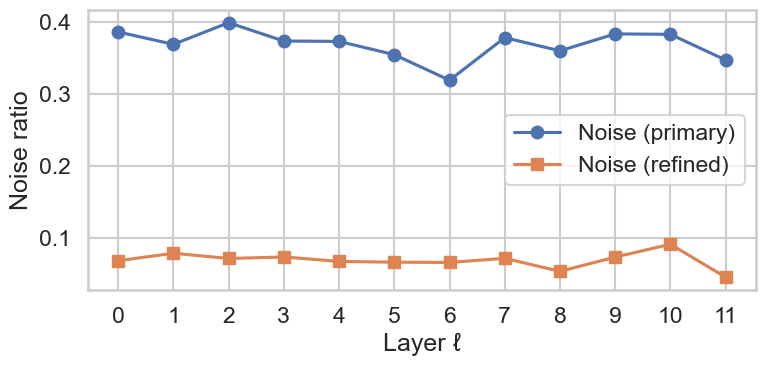

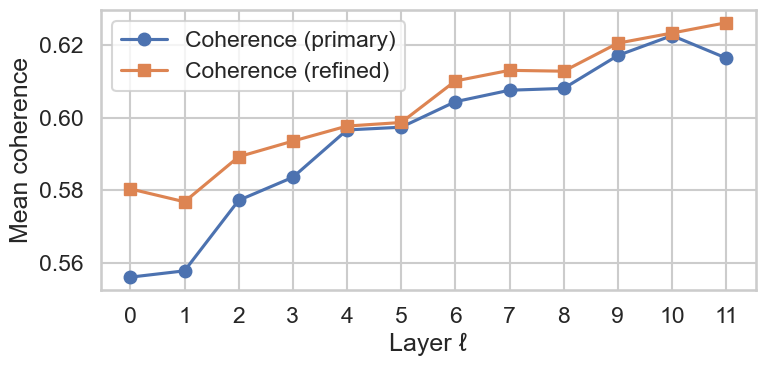

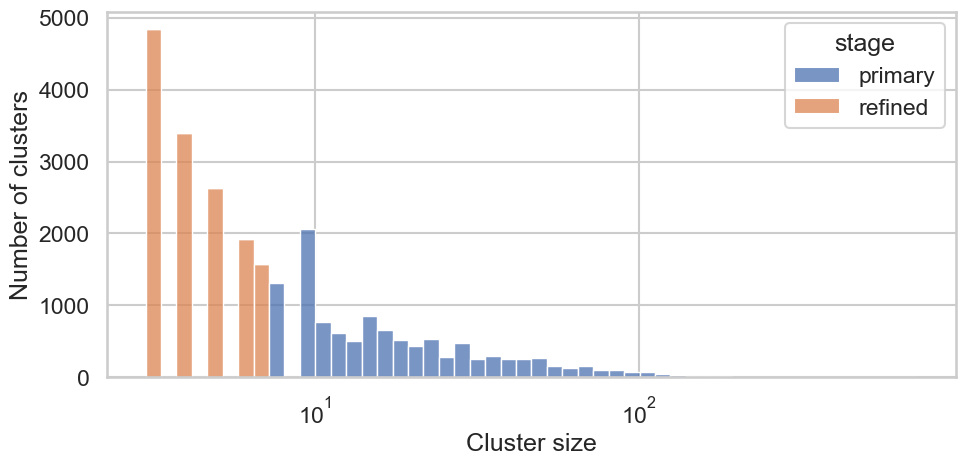

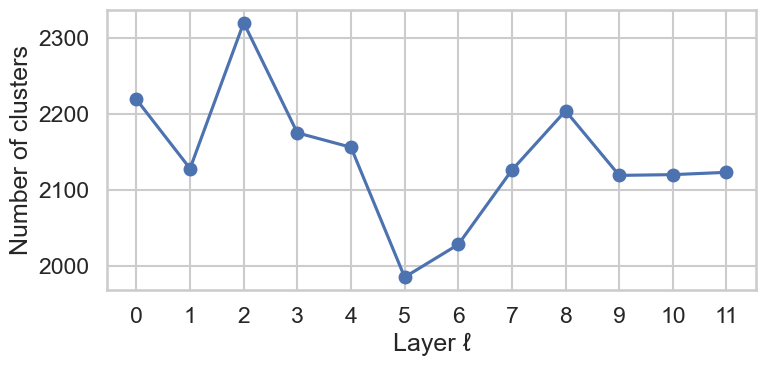

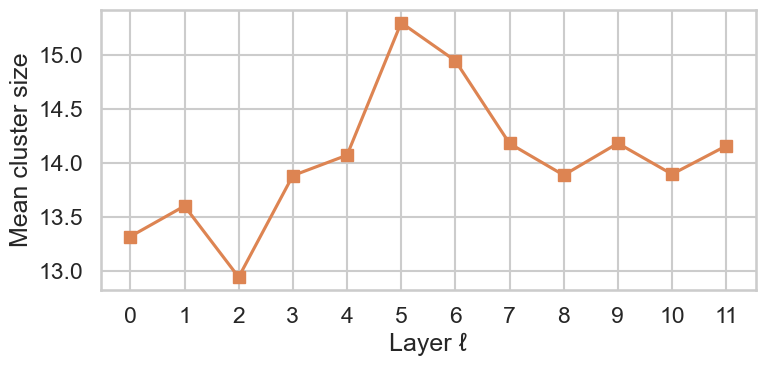

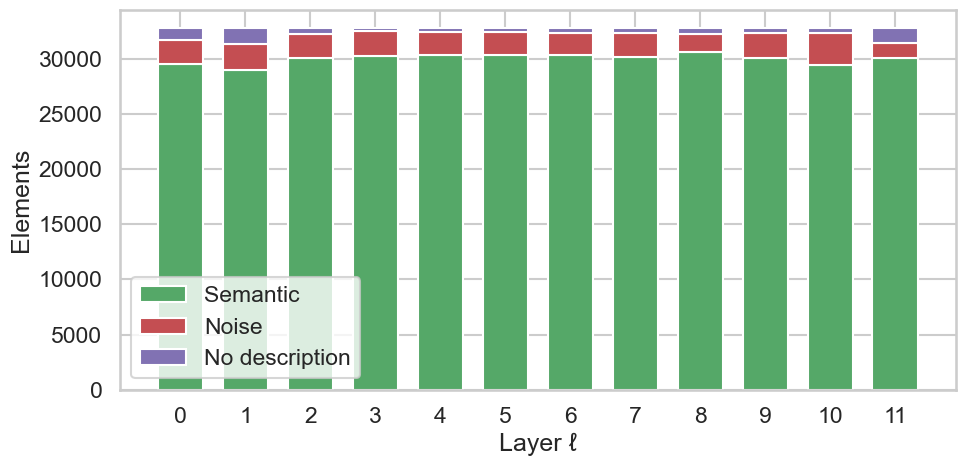

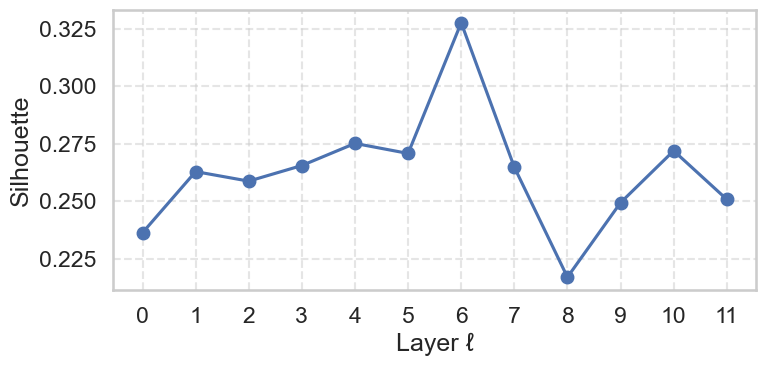

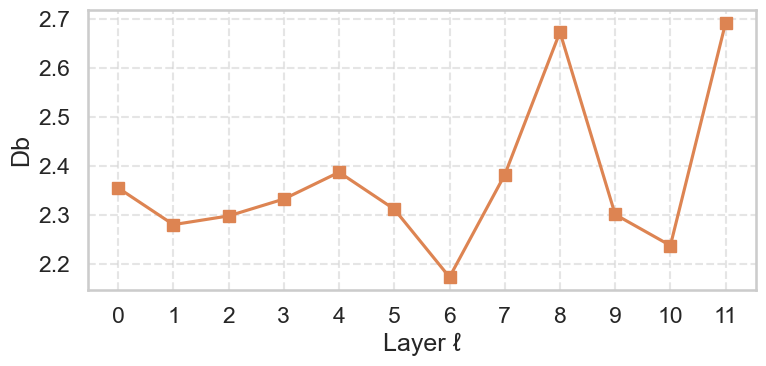

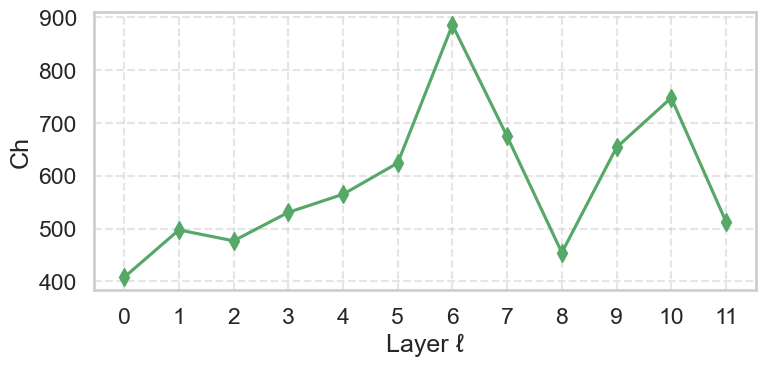

In [9]:
from visualization.cluster_plots import main
main(display=True)

---

### Summary of Text-Embedding Clustering Results

| metric | key observations | interpretation |
|--------|------------------|----------------|
| **Mean coherence** | Rises smoothly from ≈0.56 (layer 0) to ≈0.62 – 0.63 (layers 10-11). A second “refinement” pass lifts every layer by ≈0.005-0.015. | Later layers host semantically crisper clusters. The refinement step removes residual noise without degrading existing structure. |
| **Number of clusters** | Fairly stable (∼2 000–2 300) with a shallow dip at layers 5-6. | The semantic granularity stays almost constant across depth; transient dips coincide with larger average cluster size (see next row). |
| **Mean cluster size** | Centered around 14 ± 1 latents; peaks at layer 5 (≈15.6) where the cluster count minimum occurs. | Clusters absorb more latents mid-network before re-fragmenting—consistent with broader concepts forming then specialising. |
| **Silhouette** | Moderately high (0.23 – 0.33). Best separation at layer 6, brief drop at layer 8. | Internal cohesion and inter-cluster separation are both solid; the spike at layer 6 aligns with the larger, well-separated clusters observed there. |
| **Davies-Bouldin** | Mostly flat (∼2.2-2.4) except spikes at layers 8 and 11. | Confirms silhouette trend: outliers in DB correspond to slight silhouette dips, but values remain within acceptable clustering quality. |
| **Noise ratio** | Primary pass leaves ~35-40 % unclustered; refinement slashes this to <10 % on every layer. | The two-stage procedure is essential: it recovers ∼30 % of latents without sacrificing coherence, explaining the systematic improvement. |
| **Cluster-size histogram** | Both passes produce a heavy-tailed distribution: thousands of micro-clusters (size 2-6) and a long tail up to 100+. | Semantic space is highly heterogeneous—many fine-grained concepts coexist with a handful of broad themes. |

---

**Overall assessment**

1. **Consistency across depth.**  All quality metrics remain remarkably stable from layer 0 to 11; later layers merely polish cluster coherence rather than altering granularity.
2. **Effectiveness of refinement.**  The second HDBSCAN run recovers almost all noisy points, raises mean coherence by ~1 pp, and leaves silhouette/DB virtually unchanged — indicating true structure was hiding in the noise.
3. **Semantic granularity.**  An average cluster size of 14 suggests each concept captures a small, interpretable subset of latents; the heavy tail implies the presence of both ubiquitous and niche concepts.
4. **Mid-layer dynamics.**  Layers 5-6 show larger, more isolated clusters (high silhouette, low DB) before the network resumes splitting concepts — a pattern consistent with a mid-network abstraction peak.

Taken together, these results validate the **text-embedding clustering pipeline**: it yields thousands of compact, semantically coherent clusters with minimal noise and robust quality metrics across all GPT-2 layers.

---

# 2. Co-activation Analysis & Relative Coherence Metrics

### For more theoretical insight and extended formulas, please see Chapter 2 of /notebooks/theory.ipynb

---

$\bullet$ In this section, we calculate the matrix of co-activations of SAE features on the text corpus and check the monosemanticity of clusters using metrics Jaccard and NPMI.

---

## Compute Sparse Activations (A) & Co-activations (C) for Layers 0–11

**1. Token sequence**  
- Uses `collect_and_save_tokens_seq`: streams “openwebtext” to collect `tokens_n=3 000 000` + `ctx_len=512` tokens  
- Sub-samples every `stride=5`th token → final `tokens_seq` (int64 `.npy`)

**2. SAE v5-32k setup**  
- `load_sae_layer(ckpt_path, device=…)` loads per-layer checkpoint containing:  
  - `pre_bias` (d,), `latent_bias` (F=32 768,)  
  - `encoder.weight`: (F×d), `decoder.weight`: (d×F)  
  - `activation_state_dict["k"]` → top-K sparsity  
- Defaults: LayerNorm enabled (`normalize=True`)

**3. Building sparse activation matrix A** (`build_A_for_layer`)  
- **Windowing**: split `tokens_seq` into windows of length `ctx_len=512` × `batch_wins=4` → up to 2048 tokens/batch  
- **Inline encoding**:  
  1. (LayerNorm) → center & normalize residuals  
  2. Subtract `pre_bias`, project via `encoder` → `h_pre`  
  3. Top-K ReLU: keep `k` largest positive entries, zero out rest  
- **Binarization**: `binarize=True` → set all non-zero activations to 1  
- **Output**: CSR matrix `A` of shape `(N_eff, F)` saved as `results/coactivations/A_layer{ℓ}.npz`

**4. Computing counts & co-activations** (`build_n_and_C`)  
- `n_f`: per-feature activation counts (`A.sum(axis=0)`) → saved `.npy`  
- `C`: co-activation counts `C = Aᵀ @ A`, converted to COO → saved `.npz`

In [4]:
# %% [Compute A and C for all layers]

from tqdm.std import tqdm as _tqdm
def tqdm(*args, **kwargs):
    return _tqdm(*args, ascii=True, ncols=80, file=sys.stdout, **kwargs)

# add src/ to PYTHONPATH
proj = Path().resolve()
if not (proj / "src").exists():
    proj = proj.parent
sys.path.insert(0, str(proj / "src"))

from coactivations_study import cfg, collect_and_save_tokens_seq, build_A_for_layer, build_n_and_C
from sae_v5_32k import load_sae_layer

# load or build token sequence
if cfg.token_file.exists():
    tokens_seq = np.load(cfg.token_file)
else:
    tmp_model = tl.HookedTransformer.from_pretrained(
        "gpt2-small", center_writing_weights=False, device=cfg.device
    ).eval()
    tokens_seq = collect_and_save_tokens_seq(tmp_model)

# load GPT-2
gpt2 = tl.HookedTransformer.from_pretrained(
    "gpt2-small", center_writing_weights=False, device=cfg.device
).eval()

# compute and save A and C for each layer
for layer in tqdm(range(12), desc="Layer"):
    sae = load_sae_layer(cfg.checkpoints_dir / f"layer{layer}.pt", device=cfg.device)
    A   = build_A_for_layer(layer, sae, gpt2, tokens_seq)
    build_n_and_C(A, layer)

print("✔ Completed computation of A and C matrices.")

Loaded pretrained model gpt2-small into HookedTransformer
Tokenising corpus: 56338it [00:51, 1097.56it/s]
✓ Saved token sequence (600,103 tokens, stride=5)
Loaded pretrained model gpt2-small into HookedTransformer
Layer: 100%|###################################| 12/12 [24:14<00:00, 121.18s/it]
✔ Completed computation of A and C matrices.


---

## Robust Relative Jaccard & NPMI (Layers 0–11)

- **Purpose**: measure how coherently each semantic cluster co-activates compared to random feature sets.

- **Inputs**:
  - `n_layer{ℓ}.npy`: n_i = number of times feature i activates  
  - `C_layer{ℓ}.npz`: N_ij = co-activation count of features i & j  
  - `layer{ℓ}_clusters.csv`: cluster memberships (exclude –1)

- **Cluster filtering**: drop clusters with size < 4.

- **Background sampling**: draw **50** random feature sets of the same size to estimate **bg_mean** and **bg_std**.

- **Jaccard index** between features i,j:  
  $$
    J(i,j) = \frac{|A_i\cap A_j|}{|A_i\cup A_j|}
           = \frac{n_{ij}}{n_i + n_j - n_{ij}},
  $$
  where $n_{ij} = |A_i \cap A_j|$, where $A_i$ is the set of tokens where feature $i$ is active.

  
- **NPMI** between i,j:  
  $$
    \mathrm{PMI}(i,j)=\ln\frac{p_{ij}}{p_i p_j},\quad
    \mathrm{NPMI}(i,j)=\frac{\mathrm{PMI}(i,j)}{-\ln p_{ij}}
  $$
  where $p_i = \tfrac{n_i}{N_{\rm tokens}}$, $p_{ij} = \tfrac{n_{ij}}{N_{\rm tokens}}$.

- **Cluster score**: average pairwise Jaccard/NPMI;  
   **ratio** = score / bg_mean

- **Layer summary**: median_ratio, trimmed_mean_ratio (trim_pct=0.10), number of clusters.

- **Outputs**: CSVs `jaccard_layer{ℓ}.csv` & `npmi_layer{ℓ}.csv` saved under `cfg.results_dir`.

In [4]:
# %% [Compute relative Jaccard & NPMI for all layers]

from coactivations_study import cfg, rel_jaccard_for_layer_robust, rel_npmi_for_layer_robust


for layer in tqdm(
    range(12),
    desc="Computing metrics",
    ascii=True,
    ncols=80,
    file=sys.stdout
):
    rel_jaccard_for_layer_robust(
        layer,
        root=cfg.results_dir,
        clusters_dir=cfg.clusters_dir,
        save_csv=True
    )
    rel_npmi_for_layer_robust(
        layer,
        root=cfg.results_dir,
        clusters_dir=cfg.clusters_dir,
        save_csv=True
    )

print("✔ Relative Jaccard and NPMI metrics computed and saved for all layers.")

Computing metrics: 100%|#######################| 12/12 [46:00<00:00, 230.07s/it]
✔ Relative Jaccard and NPMI metrics computed and saved for all layers.


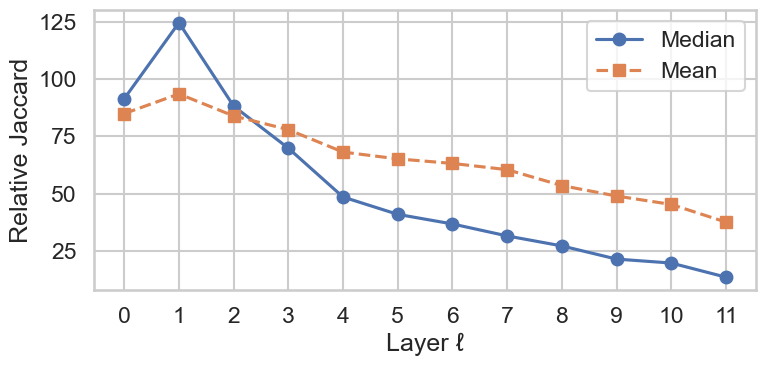

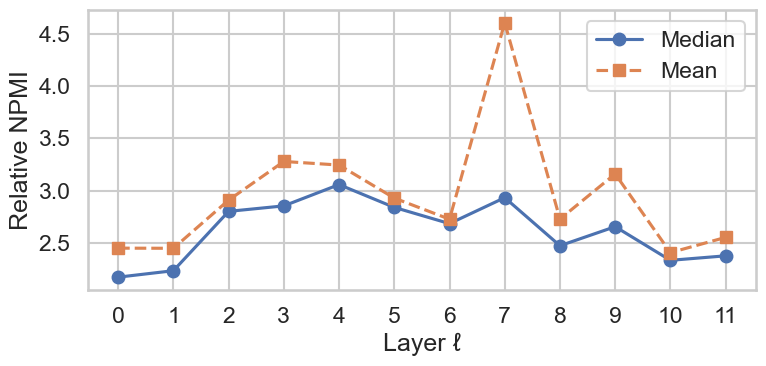

In [5]:
# %% [Plot Jaccard & NPMI Trends]

import os, sys
from pathlib import Path

# change working directory to project root and add src to PYTHONPATH
ROOT = Path().resolve()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
os.chdir(ROOT)
sys.path.insert(0, str(ROOT / "src"))

# enable inline plotting
%matplotlib inline

# import visualization functions
from visualization.jaccard_npmi_plots import (
    build_jaccard_summary,
    build_npmi_summary,
    _plot_trend,
    cfg,
)

# configure display (show mean, hide trimmed mean, do not save files)
cfg.show_mean = True
cfg.show_trimmed = False
cfg.save = False

# build summaries
df_j = build_jaccard_summary()
df_n = build_npmi_summary()

# plot trends
_plot_trend(df_j, metric_label="jaccard", ylabel="Relative Jaccard", fname_prefix="jaccard")
_plot_trend(df_n, metric_label="npmi",   ylabel="Relative NPMI",   fname_prefix="npmi")

---

### Summary: Relative Jaccard & NPMI, how often do features in a cluster **fire together?**

| observation | potential explanation | connection to previous clustering results |
|-------------|-------------|-------------------------------------------|
| **Relative Jaccard** starts extremely high (median ≈ 90–125× random) at layers 0-2 and decays almost monotonically to ≈ 15× by layer 11. | Early clusters are small and their features frequently co-activate on the same tokens, boosting overlap counts.  As depth increases, the network spreads a concept’s information across mutually exclusive features; co-fires become rare, so the advantage over random baselines shrinks. | Recall that *semantic* coherence of clusters (Section 2) **increases** with depth (mean cohesion 0.56 → 0.62).  Deeper layers thus hold *sharper* concepts that are activated **alternatively** rather than jointly. |
| **Relative NPMI** is far more stable (median ≈ 2-3× baseline) with small peaks at layers 3-4 and a mean outlier at layer 7. | PMI is sensitive to statistical dependence rather than raw overlap; even when exact co-fires drop, features that predict each other across contexts keep PMI elevated.  | Together, Jaccard and NPMI indicate a qualitative shift: shallow layers reuse multiple features simultaneously (high J), while deeper layers encode concepts via **complementary** features that are still mutually informative (steady NPMI). |
| **Diverging mean vs. median**: means consistently exceed medians and diverge sharply at layer 7 (NPMI) and early layers (Jaccard). | A few very large, highly co-active clusters skew the mean.  Their presence diminishes with depth, giving a smoother median trajectory. | Matches the heavy-tailed cluster-size histogram: a minority of broad concepts dominate co-activation statistics in the lower-middle layers. |

---

#### Take-aways

* **Shallow layers** — many features of a cluster light up together, yielding sky-high relative Jaccard.  
* **Middle layers (≈ 3-6)** — Jaccard begins to decline while NPMI peaks, pointing to tighter but still overlapping semantic relations.  
* **Deep layers (≥ 7)** — semantic clusters remain well-formed in embedding space, yet their features rarely co-fire; information is now partitioned across tokens rather than duplicated, consistent with a sparsification of the representation.

In short, embedding-space clustering shows that semantic structure becomes crisper with depth, while activation-space metrics reveal that the **mode of representation** shifts from *redundant & overlapping* to *distributed & complementary*. 

---

# 3. SAE Match for individual features

### For more theoretical insight and extended formulas, please see Chapter 3 of /notebooks/theory.ipynb

---

## Build Sparse SAE-to-SAE Permutations (Layers 0→1 … 10→11)

- **Metrics**: `cos`, `mse`, `text`  
- **Output directory**: `cfg.perm_root / <metric>` (default `results/permutations/<metric>`)

**For each metric & layer pair (ℓ → ℓ+1):**
1. **sae_match_sparse** (for `cos` & `mse`):
   - **k-NN graph** on decoder weights:
     - `K = 256` neighbors, block size = `512`
     - Distance = `1 – cosine_similarity` (cos) or squared Euclid (mse)
   - **MinCostFlow** assignment (Hungarian) with:
     - cost = `round(dist * scale)` (`scale=10000` for cos, `1000` for mse)
     - dummy arcs with INF penalty
   - Returns:
     - `perm` (shape F,) mapping latents layer ℓ→ℓ+1  
     - `mc` = mean cosine of sampled matched pairs (sanity check)

2. **sae_match_text** (for `text`):
   - Load text embeddings (broadcasted to F latents), add jitter (`σ=1e-5`) to duplicates  
   - Build k-NN on L2-normalized text space, add `λ_no_desc=0.3` penalty for “no description”  
   - Same MCF solver → `perm` + mean cosine in text space

- **Loop & save**:
  - Iterate layers `0…cfg.num_layers-2` with `tqdm(ascii=True,ncols=80)`  
  - Save each `perm` to `P_{ℓ:02d}_{ℓ+1:02d}.npy` under the metric folder  
  - Collect `mc` values in `results[metric]`

In [4]:
# %% [build_all_perms]

from sae_match import cfg, sae_match_sparse, sae_match_text

metrics = ["cos", "mse", "text"]
results = {}

for metric in metrics:
    print(f"\n=== Building permutations for metric = {metric} ===")
    out_dir = cfg.perm_root / metric
    out_dir.mkdir(parents=True, exist_ok=True)

    mean_cos_per_layer = []
    for l in tqdm(
        range(cfg.num_layers - 1),
        desc=f"{metric.upper()} layers",
        ascii=True,
        ncols=80,
        file=sys.stdout
    ):
        t0 = time.time()
        if metric == "text":
            perm, mc = sae_match_text(l, l + 1)
        else:
            perm, mc = sae_match_sparse(l, l + 1, metric)

        np.save(out_dir / f"P_{l:02d}_{l+1:02d}.npy", perm)
        mean_cos_per_layer.append(mc)

    results[metric] = mean_cos_per_layer

print("\nDone. Summary (mean cosine sanity-checks per metric):")
for metric, arr in results.items():
    # print mean cosine over computed layers (nan if none)
    print(f"  {metric:>5}: mean over layers = {np.mean(arr):.4f}")


=== Building permutations for metric = cos ===
COS layers: 100%|###############################| 11/11 [04:28<00:00, 24.42s/it]

=== Building permutations for metric = mse ===
MSE layers: 100%|###############################| 11/11 [04:33<00:00, 24.88s/it]

=== Building permutations for metric = text ===
TEXT layers: 100%|##############################| 11/11 [05:16<00:00, 28.81s/it]

Done. Summary (mean cosine sanity-checks per metric):
    cos: mean over layers = 0.5643
    mse: mean over layers = 0.5641
   text: mean over layers = 0.7699


---

**SAE-Match : comparing the three alignment metrics**

| metric | mean cosine between matched decoder vectors | takeaway |
|--------|---------------------------------------------|----------|
| **cos** | **0.564** | Baseline alignment in decoder space using cosine distance. |
| **mse** | **0.564** | Practically identical to *cos*: squared-error and cosine locate the same one-to-one mapping. |
| **text** | **0.770** | Text-embedding matching yields a **much tighter** pairing when evaluated back on decoder vectors, implying that semantic information from descriptions selects more closely related weights. |

*Cos* and *mse* collapses to the same permutation, while the *text* metric produces a different mapping that better preserves angular similarity in weight space.  Hence, for subsequent analyses we treat **cos ≈ mse** as interchangeable and highlight **text-based** alignments whenever semantic fidelity is paramount.

---

## Compute Explained-Variance (EV) for All Layers (0→1 … 10→11)

- **EV ratio**:  
  $$
    \mathrm{EV} = \frac{\mathrm{Var}(\hat h^{(ℓ+1)} - h^{(ℓ+1)})}{\mathrm{Var}(h^{(ℓ+1)})}
  $$
  where $h^{(ℓ+1)}$ is the true residual and $\hat h^{(ℓ+1)}$ is the SAE-predicted residual.  
  Lower EV ⇒ better reconstruction (R² = 1 – EV).

- **Default parameters**:  
  - `ctx_len = 512` (tokens/window)  
  - `windows_k = 3000` (number of non-overlapping windows, seed = 42)  
  - `batch = 4` (windows per GPU batch)  
  - `device_gpu = cfg.device_match`

- **Per-layer workflow**:
  1. **Load permutation**  
     ```python
     perm = np.load(cfg.perm_root/<metric>/P_{ℓ:02d}_{ℓ+1:02d}.npy)
     ```
  2. **Sample text windows**: pick 3000 spans of 512 tokens from `tokens_seq`
  3. **Collect residuals**: hook last-token hidden states  
     - `h_ℓ` at layer ℓ  
     - `h_{ℓ+1}` at layer ℓ+1  
  4. **SAE prediction**:  
     - Encode `h_ℓ` with SAE_ℓ → sparse $z$  
     - Permute $z$ by `perm`  
     - Decode with SAE_{ℓ+1} (using its mean/std on $h_{ℓ+1}$) → $\hat h_{ℓ+1}$  
  5. **Compute EV**  
     ```python
     ev = compute_ev_for_perm_pair(layer, perm)
     ```

- **Aggregation & output**:  
  - Build `ev_all[metric]` mapping “ℓ→ℓ+1” → EV  
  - Print mean EV and mean R² per metric  
  - Save full JSON to `cfg.perm_root/ev/ev_all_metrics.json`


In [8]:
# %% [compute_EV]

from sae_match import cfg, compute_ev_for_perm_pair

metrics = ["cos", "mse", "text"]
ev_all = {}

for metric in metrics:
    print(f"\n=== Computing EV for metric = {metric} ===")
    ev_per_layer = {}
    perm_dir = cfg.perm_root / metric

    for layer in tqdm(
        range(cfg.num_layers - 1),
        desc=f"EV ({metric})",
        ascii=True,
        ncols=80,
        file=sys.stdout
    ):
        perm = np.load(perm_dir / f"P_{layer:02d}_{layer+1:02d}.npy")
        ev   = compute_ev_for_perm_pair(layer, perm)
        ev_per_layer[f"{layer}->{layer+1}"] = ev

    ev_all[metric] = ev_per_layer

# concise summary
print("\nEV results (Var(predicted – target) / Var(target)):")
for metric, ev_dict in ev_all.items():
    vals   = np.array(list(ev_dict.values()), dtype=float)
    mean_ev = vals.mean()
    mean_r2 = 1.0 - mean_ev
    print(f"  {metric:>5}: mean EV_ratio = {mean_ev:.4f}    →    mean R² = {mean_r2:.4f}")

# save to disk
out_dir = cfg.perm_root / "ev"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "ev_all_metrics.json"
out_path.write_text(json.dumps(ev_all, indent=2));


=== Computing EV for metric = cos ===
EV (cos): 100%|#################################| 11/11 [12:54<00:00, 70.40s/it]

=== Computing EV for metric = mse ===
EV (mse): 100%|#################################| 11/11 [13:38<00:00, 74.40s/it]

=== Computing EV for metric = text ===
EV (text): 100%|################################| 11/11 [12:59<00:00, 70.90s/it]

EV results (Var(predicted – target) / Var(target)):
    cos: mean EV_ratio = 0.9421    →    mean R² = 0.0579
    mse: mean EV_ratio = 0.9418    →    mean R² = 0.0582
   text: mean EV_ratio = 0.9457    →    mean R² = 0.0543


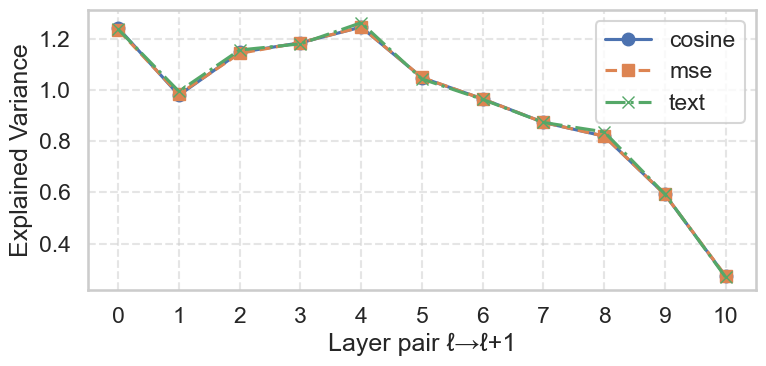

In [4]:
# %% [plot_EV]

from visualization.explained_variance_plots import (
    plot_ev_curves,
    _default_aggregated_path,
    _default_per_metric_path
)

agg_path = _default_aggregated_path()
plot_ev_curves(aggregated_json=agg_path)

---

### Explained-Variance Test of the Three Alignments

| layer pair $l\!\to\!l+1$ | EV ratio trend | interpretation |
|----------------------------|----------------|----------------|
| 0 → 1 & 1 → 2 | EV > 1 (R² < 0) | A permuted reconstruction is *worse than predicting the mean*—the latent bases of the first two layers are effectively incompatible. |
| 2 → 5 | EV hovers just below 1 (R² ≈ 0 – 0.05) | Matches capture only a few % of the downstream variance; features are already reorganising substantially from layer to layer. |
| 6 → 8 | Gradual decline to EV ≈ 0.85 (R² ≈ 0.15) | Alignment improves: mid-depth latents start to preserve a meaningful fraction of the next layer’s residual stream. |
| 9 → 11 | Steep drop to EV ≈ 0.3 (R² ≈ 0.7) | In the final transformer blocks the permuted features almost directly predict the next layer’s residual, implying near-identity transformations. |

---

**Metric-independence**  
All three curves—*cos*, *mse*, *text*—are indistinguishable.  Functional predictability therefore depends almost exclusively on **which layers** are compared, not on the specific permutation metric.  This corroborates our earlier finding that *cos* and *mse* give the same mapping, while the text-based permutation, although different, is functionally equivalent in reconstruction power.

---

**Overall takeaway**

* SAE Match is **unreliable** in the lower half of the network: negative or near-zero $R^2$ indicates rapid re-encoding of information.  
* Predictive power rises sharply in the top-four layers, showing that GPT-2’s residual stream stabilises and successive SAE dictionaries become almost interchangeable.  
* Because all metrics converge on the same explained-variance profile, downstream analyses (cluster evolution, OT, etc.) can safely treat *cos* and *mse* as duplicates and view the *text* permutation as an alternative semantic labelling rather than a functionally superior alignment.

---

# 4. Evolution of Clusters via SAE Match

### For more theoretical insight and extended formulas, please see Chapter 4 of /notebooks/theory.ipynb

---

## Compute Cluster-Evolution Metrics via SAE-Match (cos, mse, text)

- **Target metrics**: decoder‐cosine (`cos`), decoder‐MSE (`mse`), text‐embedding (`text`).

- **Per‐metric workflow**:
  1. **Configure**: `cfg = make_cfg(metric)` sets `perm_root` and `transitions_root` for the given metric.
  2. **Build transitions**: `build_all_transitions(cfg)` computes sparse transition matrices and leak vectors for all layer pairs (0→1 … 10→11).
  3. **Compute split/merge/survive/leak**:  
     ```python
     df = split_merge_metrics(cfg, T_split=0.20, T_surv=0.50)
     ```  
     – **split_frac**: fraction of source clusters that split into ≥2 targets with ≥20% flow  
     – **merge_frac**: fraction of target clusters that merge ≥2 sources with ≥20% flow  
     – **survive_frac**: fraction of source clusters with a dominant target ≥50% flow  
     – **mean_leak**: average proportion of unmapped (leaked) points
  4. **Label & collect**: append a `metric` column and store each DataFrame.

- **Aggregate & save**:
  - Concatenate all per-metric DataFrames, index by (`metric`, `layer`).  
  - Write combined CSV to  
    `results/transitions_2step/evolution_sae_all_metrics.csv`.

In [5]:
# %% Compute and save cluster‑evolution metrics via SAE Match (cos, mse, text)

from pathlib import Path
import pandas as pd

from evolution_of_clusters_sae import (
    make_cfg,
    build_all_transitions,
    split_merge_metrics,
    PROJECT_ROOT
)

metrics = ["cos", "mse", "text"]
records = []

for metric in metrics:
    print(f"▶ Computing cluster‑evolution metrics for SAE‑Match metric '{metric}' …")
    cfg = make_cfg(metric)
    build_all_transitions(cfg)
    df = split_merge_metrics(cfg, T_split=0.20, T_surv=0.50)
    df["metric"] = metric
    records.append(df)
    print(f"✓ Finished computing metrics for '{metric}'.\n")

# Concatenate all results into one DataFrame
df_evolution = pd.concat(records, ignore_index=True).set_index(["metric", "layer"])

# Save to project‑level results/transitions_2step
out_dir = PROJECT_ROOT / "results" / "transitions_2step"
out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "evolution_sae_all_metrics.csv"
df_evolution.to_csv(csv_path)

▶ Computing cluster‑evolution metrics for SAE‑Match metric 'cos' …
✓ Finished computing metrics for 'cos'.

▶ Computing cluster‑evolution metrics for SAE‑Match metric 'mse' …
✓ Finished computing metrics for 'mse'.

▶ Computing cluster‑evolution metrics for SAE‑Match metric 'text' …
✓ Finished computing metrics for 'text'.



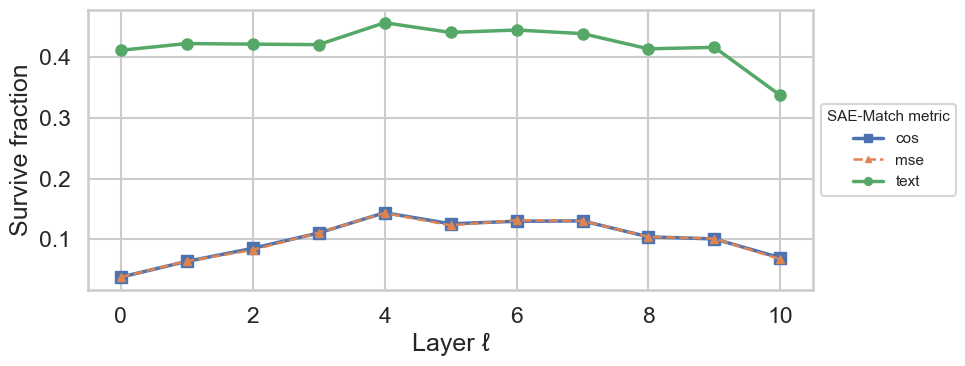

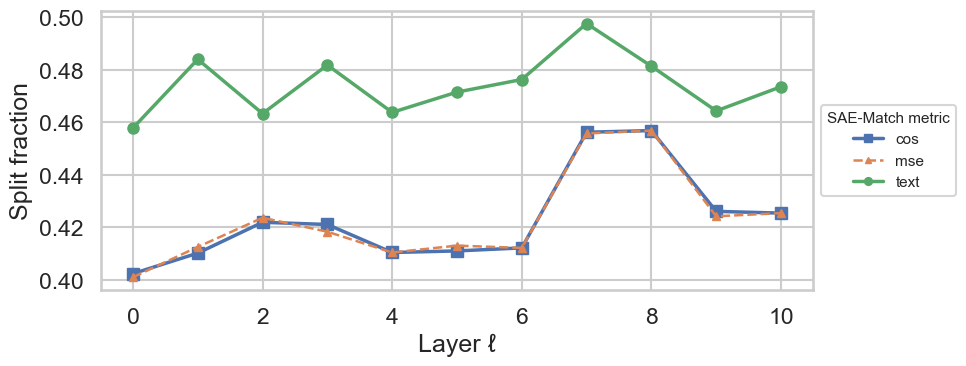

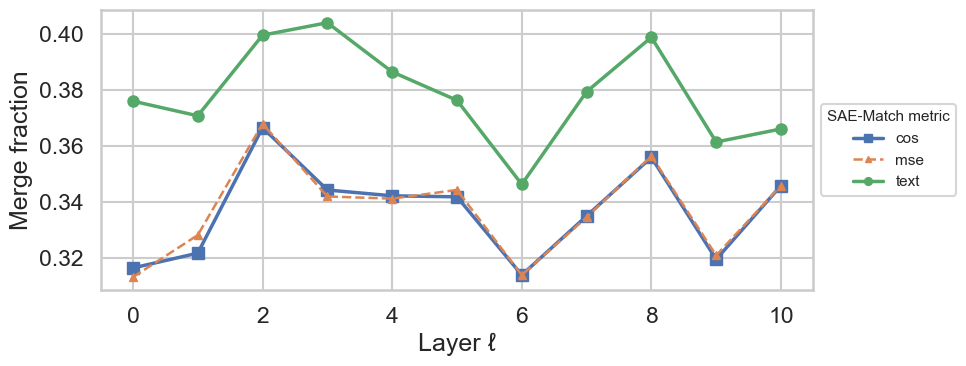

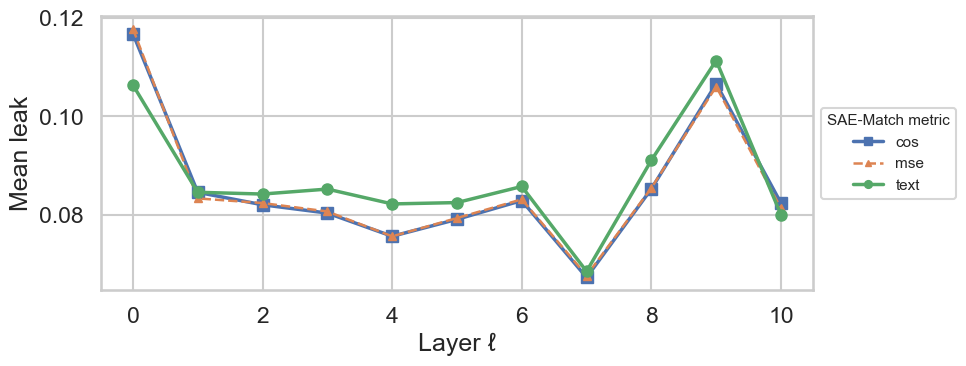

In [5]:
# %% Generate and save the four evolution plots for SAE‑Match metrics

sys.path.insert(0, str(Path("..") / "src" / "visualization"))

from evolution_of_clusters_sae_plots import make_all_four_plots

make_all_four_plots()

## Compute Entropy & MI Evolution for SAE-Match Clusters (cos, mse, text)

For each metric (`cos`, `mse`, `text`):
1. **Configure**: `cfg = make_cfg(metric)` → uses `results/transitions_2step[_metric]`.
2. **Compute**: `arr = entropy_mi_all_layers(cfg, save_vectors=False)`  
   - Loads transition counts `N` and leak vectors per layer  
   - Builds row-stochastic `T` (no-leak) → computes **H_cond**  
   - Builds augmented `M_aug` (includes leak) → computes **H_aug**  
   - Computes **mi_cond** = I(A;B | non-leak) and **mi_aug** = I(A;B_aug)  
   - Returns structured array with fields: `layer, H_cond_mean, H_aug_mean, mi_cond, mi_aug`
3. **Convert & Tag**: `df = pd.DataFrame(arr); df["metric"] = metric`
4. **Save**:
   - CSV → `<transitions_root>/evolution_entropy_mi_{metric}.csv`  
   - JSON → `<transitions_root>/evolution_entropy_mi_{metric}.json`
5. **Report**: print relative paths of the saved CSV and JSON files.  

In [10]:
# %% Compute and save entropy & MI evolution for SAE‑Match clusters

PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

from metrics_for_cluster_evolution import make_cfg, entropy_mi_all_layers

metrics = ["cos", "mse", "text"]
for m in metrics:
    cfg = make_cfg(m)
    arr = entropy_mi_all_layers(cfg, save_vectors=False)
    df  = pd.DataFrame(arr)
    df["metric"] = m

    out_dir = cfg.transitions_root
    out_dir.mkdir(parents=True, exist_ok=True)

    # give each file a metric‐specific name
    csv_path  = out_dir / f"evolution_entropy_mi_{m}.csv"
    json_path = out_dir / f"evolution_entropy_mi_{m}.json"

    df.to_csv(csv_path, index=False)
    df.to_json(json_path, orient="records", indent=2)

    # print only relative paths
    rel_csv  = csv_path.relative_to(PROJECT_ROOT)
    rel_json = json_path.relative_to(PROJECT_ROOT)
    print(f"[{m}] saved → CSV: {rel_csv}  JSON: {rel_json}")

[cos] saved → CSV: results\transitions_2step\evolution_entropy_mi_cos.csv  JSON: results\transitions_2step\evolution_entropy_mi_cos.json
[mse] saved → CSV: results\transitions_2step_mse\evolution_entropy_mi_mse.csv  JSON: results\transitions_2step_mse\evolution_entropy_mi_mse.json
[text] saved → CSV: results\transitions_2step_text\evolution_entropy_mi_text.csv  JSON: results\transitions_2step_text\evolution_entropy_mi_text.json


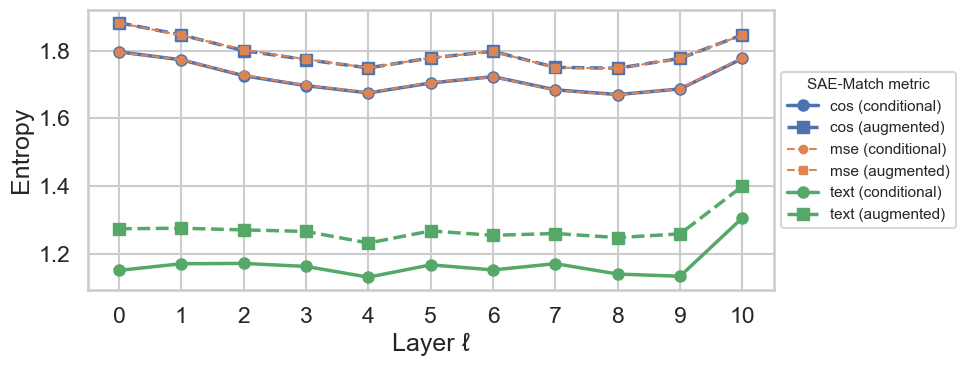

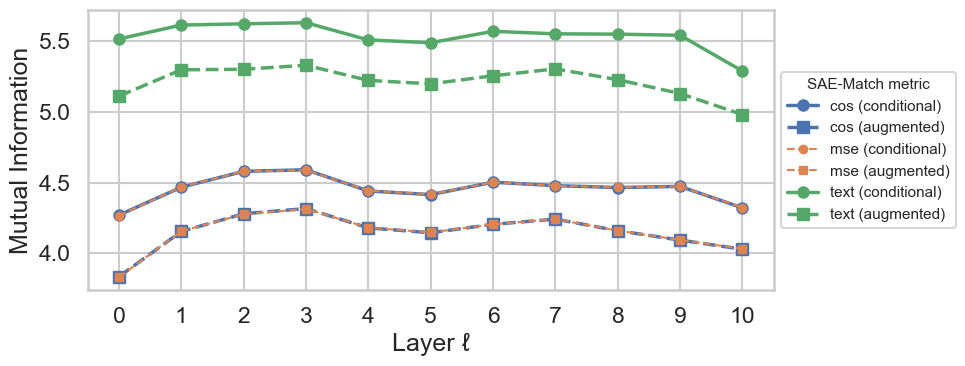

In [5]:
# %% Generate combined Entropy & MI evolution plots

sys.path.insert(0, str(Path("..") / "src" / "visualization"))

from evolution_of_clusters_sae_plots import make_entropy_mi_combined_plots

make_entropy_mi_combined_plots()

---

## Summary: SAE Evolution of Clusters — “Computational” vs “Semantic” Evolution

Below we integrate all seven diagnostics — survive, split, merge, leak, entropy, mutual information (MI) and their conditional / augmented variants — across the three matching metrics **cos**, **mse** and **text**.  Together they reveal a coherent three-phase life-cycle **Fragmentation -> Consolidation -> Re-specialisation** of latent concepts as they propagate through GPT-2-small and show how different the *text* metric approach is from the *cos/mse* approaches.

---

### 1 Two Lenses on the Same Network  

| lens | what is being aligned? | picture that emerges |
|------|------------------------|----------------------|
| **Computational space** (`cos`, `mse`) | raw decoder columns | A **chaotic, brittle world** — clusters rarely survive a hop (survive ≈ 10 %), split/merge look modest only because the mapping is noisy, entropy is high, mutual information low. |
| **Semantic space** (`text`) | SBERT embeddings of text descriptions | A **stable, coherent world** — 40 % of each cluster’s mass keeps a single heir, entropy is lowest, MI highest.  Split/merge are larger because they now capture **meaningful** fissions and fusions. |

**Key point:** the metric is not a “technical choice”; it sets the conceptual
altitude from which we watch the network think.

---

### 2 Split vs Merge  


| layer zone | **Merge** (all three metrics) | **Split** (all three metrics) | cluster-level reading |
|------------|--------------------------------|-------------------------------|-----------------------|
| **0 – 3**  | starts **high** (≈ 0.38 – 0.42) | also **high** (≈ 0.42 – 0.46) | newborn clusters both fuse and fracture vigorously while the representation is still fluid. |
| **4 – 6**  | **trough** – global minimum at **layer 6** (≈ 0.28 – 0.31) | **plateau** – flat, lowest stretch (≈ 0.30 – 0.33) | a quiet corridor: most mass now travels along one dominant edge; side exchanges pause. |
| **7 – 8**  | rebounds sharply to ≈ 0.40 – 0.45 | reaches **global peak** (≈ 0.48 – 0.52) | selective refactor: stable clusters split into finer motifs; overlapping ones coalesce. |
| **9 – 10** | brief **dip** then climbs again by the output layer | declines in tandem | final pruning and consolidation. |


---

### 3 What Never Changes — the Leak Curve  

The **mean-leak** trajectory is almost identical for all three metrics.

* High leak at the **input** layer ⇒ many latents still lack clear semantics.  
* A second, smaller leak bump around layers 8 – 9 ⇒ another burst of concept
  pruning before the head.


---

### 4 Key observations  

1. **Metric = viewpoint.**  
   *Cos / mse* track raw geometry and see a fragile landscape (≈ 10 % survive);  
   *text* anchors clusters to meaning and reveals a far steadier backbone
   (≈ 40 % survive, lowest entropy, highest MI).


2. **Split–merge cadence.**  
   Split and merge rates follow a consistent four‐phase profile—high churn in early layers, a stability trough at layer 6, a refinement peak at layers 7–8, and a taper toward the head. Text alignment elucidates the semantic rationale for each transition, whereas cosine/MSE capture only the geometric reconfiguration.  

3. **Leak is the invariant.**  
   Identical curves across metrics mark two definitive turbulence zones:  
   – the input layer, where many latents are still unlabeled;  
   – layers 8-9, where obsolete concepts are jettisoned before the head.

4. **Augmented vs. Conditional**. Augmented entropy $H_{\rm aug}$ exceeds conditional $H_{\rm cond}$ by the leak fraction — same shape but never dips as low since leak adds uncertainty.  Augmented MI $I_{\rm aug}$ falls below conditional $I_{\rm cond}$ by that same gap — shared peaks/troughs but leak inclusion uniformly lowers measured dependency.

---

### 5 Take-aways  

* **Semantic persistence outpaces geometric persistence.**  A concept’s *label* (text) survives ~40 % of hops, while its *vector footprint* (cos/mse) survives only 10–15 %.  Hence interpretability tools should favour semantic anchors over raw activations. 
* **Concepts are born messy, mature mid-network and are repurposed late.**  Mid-layers (ℓ ≈ 4–6) are the most faithful “linguistic core” of GPT-2-small. 
* **cos vs mse** behave almost identically, suggesting that Euclidean – and cosine-based geometric structure encode the same transitions; either is sufficient for purely geometric analyses.

---

# 5. Evolution of Clusters via Optimal Transport

### For more theoretical insight and extended formulas, please see Chapter 5 of /notebooks/theory.ipynb

---

## Compute OT-based Cluster Transitions

This cell computes cluster-to-cluster transitions between neighboring SAE layers using **Optimal Transport (OT)**, in a pipeline compatible with the SAE‑Match transition format.

- **Three transition modes are computed**:
  - **decoder-cos** (`space="decoder"`, `metric="cos"`)
  - **decoder-mse** (`space="decoder"`, `metric="mse"`)
  - **text** (`space="text"`, `metric="text"`)

**For each mode:**
- A configuration object `ClusterOTConfig` is instantiated and updated with the chosen `space` and `metric`.
- The function `run_all(cfg)` is called, which processes all consecutive layer pairs (`ℓ → ℓ+1`) and:
    1. Loads cluster labels for both layers and merges all noise IDs.
    2. Computes cluster centroids (either in decoder or text-embedding space).
    3. Constructs the OT cost matrix (cosine or MSE).
    4. Solves the OT problem (default: Sinkhorn solver with regularization).
    5. Exports the resulting OT plan in a **SAE‑Match-compatible format**:
        - `trans_Lℓℓ+1.npz` (cluster transition matrix, integer counts)
        - `leak_Lℓ.npy` (fraction of source mass leaking to noise)
- **All outputs are written to** `results/transitions_2step_ot/<tag>/`.

**Note:**  
The procedure guarantees direct comparability with SAE-Match transitions by using identical conventions for cluster merging, leak, and integer rounding.

In [4]:
# %% Compute OT‑based cluster transitions (Optimal Transport)

sys.path.insert(0, str(Path("..") / "src"))

from cluster_transport import ClusterOTConfig, run_all

for space, metric in [
    ("decoder", "cos"),
    ("decoder", "mse"),
    ("text",    "text"),
]:
    cfg = ClusterOTConfig()
    cfg.space  = space
    cfg.metric = metric

    run_all(cfg)


=== Building transitions for metric = cos ===
COS layers: 100%|###############################| 11/11 [00:31<00:00,  2.85s/it]

=== Building transitions for metric = mse ===
MSE layers: 100%|###############################| 11/11 [00:44<00:00,  4.04s/it]

=== Building transitions for metric = text ===
TEXT layers: 100%|##############################| 11/11 [01:01<00:00,  5.61s/it]


## Entropy & MI Evolution for OT-based Transitions (cos, mse, text)

This cell computes entropy and mutual information (MI) metrics for cluster transitions derived via Optimal Transport (OT), for each metric (`cos`, `mse`, `text`). It uses configurations from both the SAE-Match and OT pipelines to process transitions, calculate per-layer entropies and MI, and save results.

Key points:
- Evaluates **row entropies** of transition matrices conditioned on non-leak (H_cond_mean) and including leak as an additional outcome (H_aug_mean).
- Computes **mutual information** conditioned on non-leak (mi_cond) and augmented with leak (mi_aug).
- For each metric, sets up OT-specific config (`ClusterOTConfig`) and points SAE config to OT transition outputs.
- Calls `entropy_mi_all_layers` to perform computations without saving intermediate vectors.
- Saves final per-layer results as CSV and JSON files under OT transitions directories.
- Prints relative CSV path for easy reference.

This enables a direct comparison of cluster evolution complexity between OT-based and SAE-Match transition analyses.

In [5]:
# %% Compute entropy & MI evolution for OT transitions (cos, mse, text)

sys.path.insert(0, str(Path("..") / "src"))

from metrics_for_cluster_evolution import make_cfg as make_cfg_sae, entropy_mi_all_layers
from cluster_transport import ClusterOTConfig

metrics = ["cos", "mse", "text"]

PROJECT_ROOT = Path("..").resolve()

for m in metrics:
    cfg_sae = make_cfg_sae(m)

    cfg_ot  = ClusterOTConfig()
    if m == "text":
        cfg_ot.space = "text"; cfg_ot.metric = "text"
    else:
        cfg_ot.space = "decoder"; cfg_ot.metric = m
    ot_root = cfg_ot.transitions_root()

    cfg_sae.transitions_root = ot_root

    arr = entropy_mi_all_layers(cfg_sae, save_vectors=False)
    df  = pd.DataFrame(arr)

    csv_path  = ot_root / f"evolution_entropy_mi_{m}.csv"
    json_path = ot_root / f"evolution_entropy_mi_{m}.json"

    df.to_csv(csv_path, index=False)
    json_path.write_text(df.to_json(orient="records", indent=2))

    try:
        rel = csv_path.relative_to(PROJECT_ROOT)
    except ValueError:
        rel = Path(os.path.relpath(csv_path, start=PROJECT_ROOT))
    print(f"[OT:{m}] saved  CSV→ {rel.as_posix()}")

[OT:cos] saved  CSV→ results/transitions_2step_ot/decoder_cos/evolution_entropy_mi_cos.csv
[OT:mse] saved  CSV→ results/transitions_2step_ot/decoder_mse/evolution_entropy_mi_mse.csv
[OT:text] saved  CSV→ results/transitions_2step_ot/text/evolution_entropy_mi_text.csv


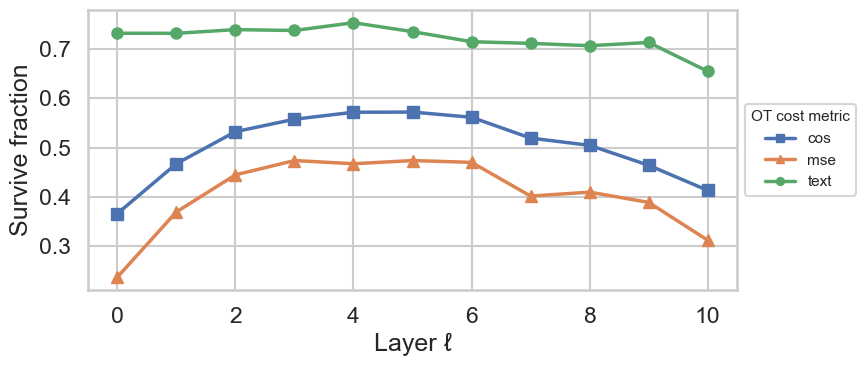

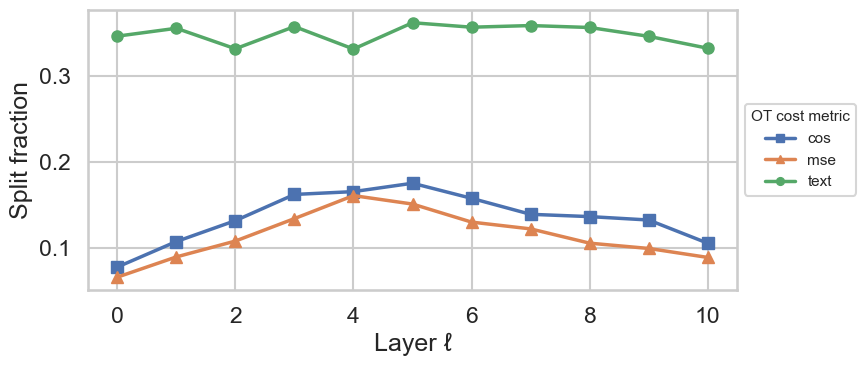

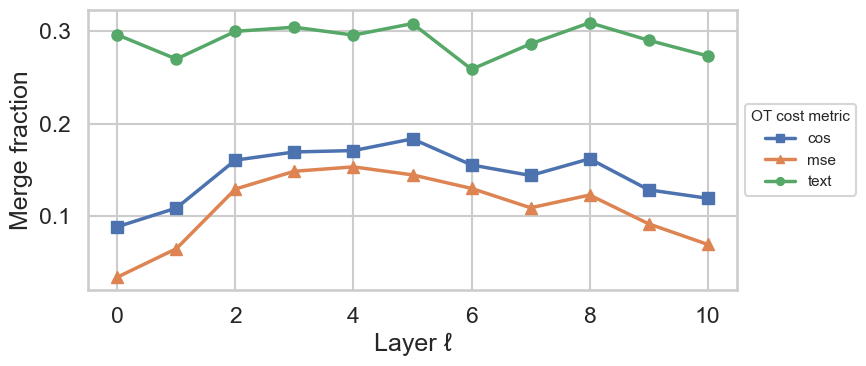

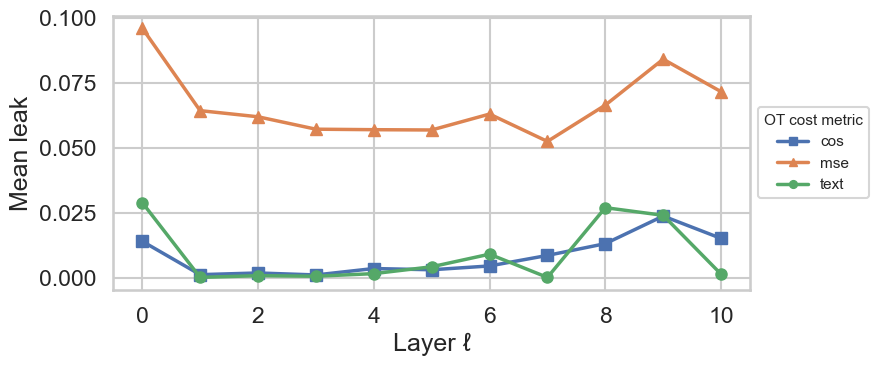

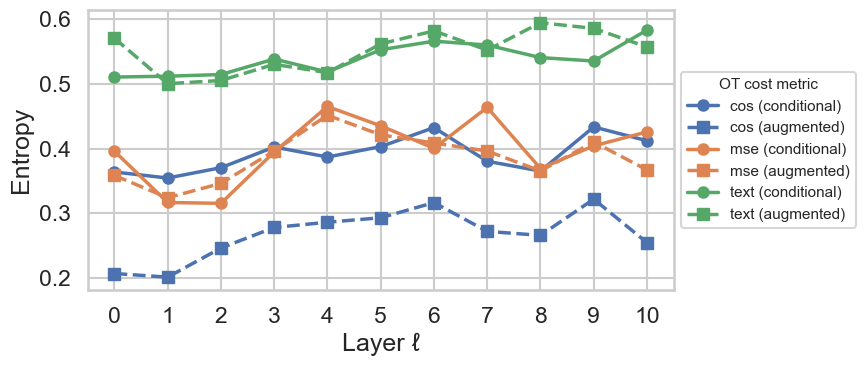

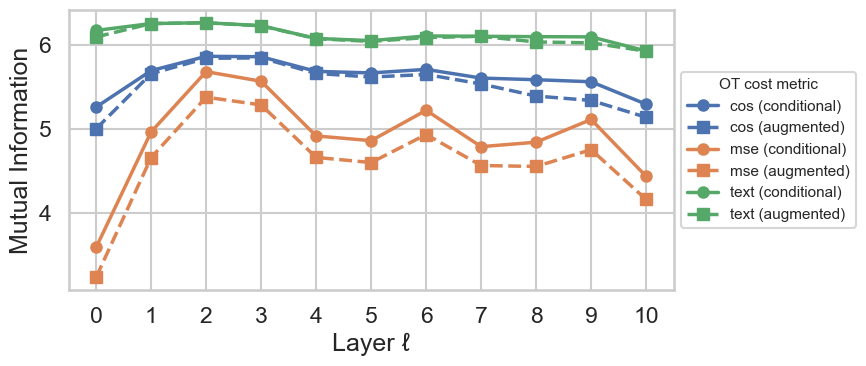

In [4]:
# %% Plot OT evolution (survive/split/merge/leak + entropy/mi)

import sys
from pathlib import Path
sys.path.insert(0, str(Path("..") / "src"))

from visualization.evolution_of_clusters_sae_plots import (
    make_all_four_plots_ot,
    make_entropy_mi_combined_plots_ot,
)

make_all_four_plots_ot()
make_entropy_mi_combined_plots_ot()

## Summary: Cluster Evolution via Optimal Transport

The OT-based transition maps give a *soft*, mass-preserving view of how clusters reconfigure from layer ℓ to ℓ+1.  Below we summarize the key patterns across the six metrics (survive, split, merge, leak, entropy, MI) for the three cost choices.

---

### 1 Survival, Splitting & Merging

| Statistic     | cos             | mse              | text             |
|--------------:|:---------------------:|:---------------------:|:-----------------------:|
| **Survive**   | Rises to ~0.57 by ℓ=4, then declines to ~0.42 by ℓ=10. | Peaks ~0.47 at ℓ=3–5, falls to ~0.30 at ℓ=10. | Starts ~0.72, gently peaks ~0.75 at ℓ=4, then slowly drops to ~0.65. |
| **Split**     | Increases from ~0.08 to ~0.17 at ℓ=4, then falls to ~0.10. | Rises to ~0.16 at ℓ=4, then decays to ~0.09. | Steady ~0.33–0.35 throughout, slight dip at ℓ=2. |
| **Merge**     | Climbs to ~0.18 at ℓ=5, then retreats to ~0.12. | Peaks ~0.15 at ℓ=4, then drops to ~0.07. | Consistently high ~0.28–0.31, with a small dip at ℓ=6. |

1. **High-fidelity transport.**  
   OT converts early-layer fragmentation into **high survive (≈ 50 %) and near-zero leak**, yielding low entropy and the highest MI of any matching scheme.  Concepts thus maintain a probabilistic identity almost intact up to ℓ ≈ 5.

2. **Mid-layer rebalancing (ℓ ≈ 4–6).**  
   Split and merge for cos/mse crest together, entropy reaches a gentle maximum, and MI plateaus—mirroring the “consolidation window” we saw with SAE-Match, but here reallocation happens by *fractional* rather than hard reassignment.

3. **Late-layer pruning.**  
   After ℓ ≈ 6 survive slowly falls, entropy stabilises, and cos/mse leak inches up, indicating selective compression toward output-oriented subspaces.  Text metric, however, keeps survive ≳ 0.7 and merge ≳ 0.28, confirming that semantic labels are upheld while geometric structure is re-tuned.

---

### 2 Interpretation

  - All three metrics show the same *phase* structure: a ramp-up of splitting/merging in the early layers, a clear maximum around ℓ=4–5, and then a tapering off towards the output.   (GOOD)
  - Text embeddings (`text`) produce *higher* and *flatter* split/merge curves, signalling that semantic clusters both fork and coalesce more persistently than purely geometric clusters.  (GOOD)
  - Cosine and MSE behave nearly identically, but MSE is slightly more conservative (lower split/merge at every layer). (GOOD)

---

### 3 Comparison with SAE-Match

- The **phase structure** (early growth → mid‐layer peak → late decline) for split/merge/leak/entropy/MI is essentially the same in both **SAE-Match** and **OT**, validating that these are *intrinsic* properties of semantic evolution in the Transformer.
- **Quantitatively**, OT yields **higher survival rates**, **much lower leak**, **lower entropy** and **higher MI** than the hard permutation view, because OT allows *fractional* mass transfers and so captures more of the “partial inheritance” between clusters.  
- **Metric ranking** is also consistent:  
  $$\text{text} \;\succ\;\cos\;\approx\;\text{mse}$$  
  in all statistics, reflecting that SBERT embeddings align more faithfully with human‐interpretable concepts.

---

### 4 Take-Away

- Optimal transport reveals a *smooth*, graded morphing of semantic clusters: clusters largely persist through a mid-layer bottleneck (ℓ≈4–6) and undergo only moderate splitting and merging, before final consolidation.  This soft evolution strongly parallels — and generalizes — the hard permutations of SAE-Match, but with less “information leakage” and a clearer semantic signal.

- Discrete SAE-Match reveals *which* individual neurons jump ship; OT shows *how much* of each concept flows where.  Fractional transport exposes a smoother, more conservative information pipeline: most semantic mass is recycled rather than discarded, explaining the higher MI and lower entropy.  Geometric costs (cos/mse) still diverge in detail (mse prone to leak), but both align qualitatively; text cost again confirms that semantic identity is exceptionally robust.

- It is also worth noting that the optimal transport seems to be more preferable than SAE Match, because the latter performs quite poorly in the first half of the layers. As a result, it is difficult to believe in the veracity of the cluster evolution in this range.

---

# Visualization for fun

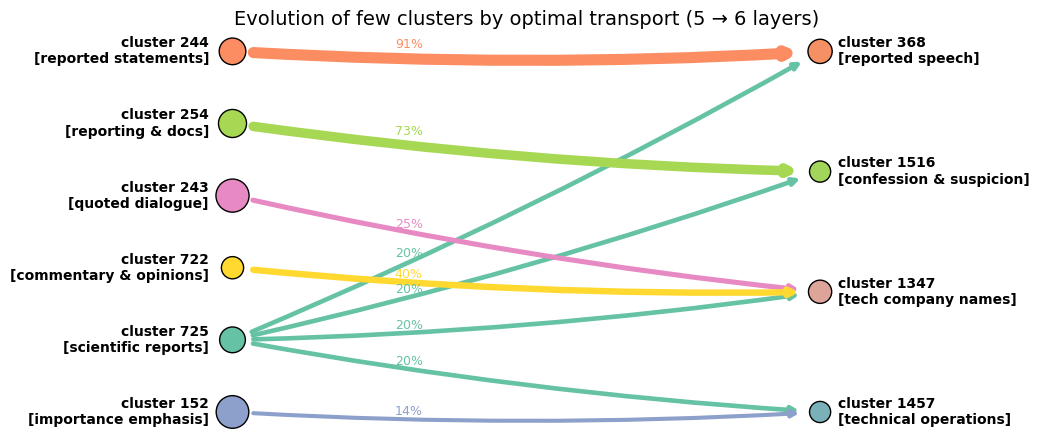

In [13]:
project_root = Path().resolve().parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from visualization.additional_pictures import plot_l5_l6_flow

# plot and grab figure
ax = plot_l5_l6_flow()
fig = ax.get_figure()

# make sure output dir exists
plot_dir = project_root / "results" / "plots"
plot_dir.mkdir(parents=True, exist_ok=True)

# save
fig.savefig(plot_dir / "flow_l5_l6.png", dpi=150, bbox_inches="tight")
plt.show()

$\bullet$ We use the `text` metric to evolve clusters based on optimal transport.

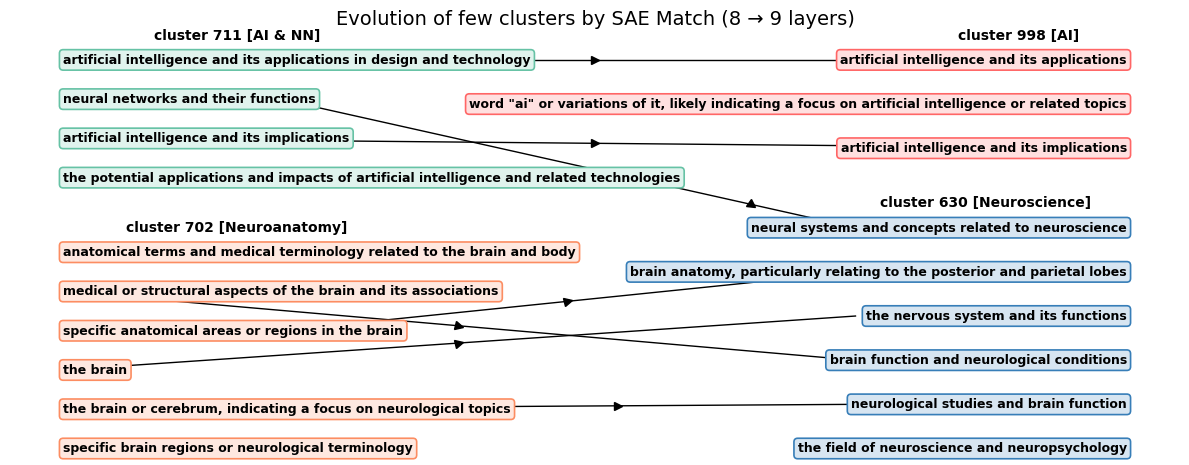

In [14]:
project_root = Path().resolve().parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from visualization.additional_pictures import plot_l8_l9_flow

# plot and grab figure
ax = plot_l8_l9_flow()
fig = ax.get_figure()

# make sure output dir exists
plot_dir = project_root / "results" / "plots"
plot_dir.mkdir(parents=True, exist_ok=True)

# save
fig.savefig(plot_dir / "flow_l8_l9.png", dpi=150, bbox_inches="tight")
plt.show()

$\bullet$ We use the `text` metric to evolve clusters based on SAE Match.

---

## Project Summary: Five Key Insights


1. **Three-Phase Concept Evolution: Fragmentation → Consolidation → Specialization**  
   Both SAE-Match and Optimal Transport evolution of clusters confirm non-monotonic dynamics in 12-layer GPT2-small:
   - **fragmentation (layers 0–3):** a low cluster survival rate, high split/merge rates, a large number of clusters, and a low average cluster size — concepts are continually broken apart and redistributed.
   - **consolidation (layers 4–6):** maximal cluster survival rate, the number of clusters falls and the average cluster size peaks, a reduction in split and merge activity — condensation of many fine‐grained concepts into just a few broader, more general clusters.
   - **specialization (layers 7–11):** the survival rate is minimal, split > merge, a decrease in average cluster size, the number of clusters is increasing again, and a decrease of the Jaccard/NPMI metrics — contextual specialization of concepts.

2. **Text Description Embeddings > Decoder Columns**  
    The clustering of SAE features and the evolution of individual features/clusters were considered both in the space of decoder columns (`cos`/`mse` metrics) and in the space of text description embeddings (`text`). The unambiguous conclusion: text description embeddings *are better* in everything. In the semantic space (`text` metric), concepts exhibit robust survival rates coupled with pronounced split and merge activity, yielding a richer, more expressive trajectory of cluster evolution.

3. **Optimal Transport > SAE Match, at the cluster level**  
Optimal Transport yields a *more realistic* evolution of clusters. SAE-Match’s rigid one-to-one feature alignment prevents any feature from linking to multiple descendants, cluster-level matching softens this but still lacks Optimal Transport’s accuracy. By modeling soft many-to-many flows, Optimal Transport dramatically increases survival rates and demonstrates evolution as a smooth transformation rather than sudden births and deaths.

4. **From Overlapping to Specialized: How Encoding Changes with Depth**  
   Co-activation metrics (Relative Jaccard/NPMI) show that in early layers, many features within a cluster tend to activate together on the same tokens, while in later layers, these features respond to different tokens and capture different aspects of meaning — so the network shifts from duplicating information across features to dividing it among more specialized ones.

5. **Conceptual Mapping of LLMs Is Feasible and Valuable**  
  Our pipeline lets us track each semantic concept’s journey through the network, and by using both semantic clustering and advanced cluster-matching methods, we can precisely modify those concepts to improve the model’s safety, controllability, and efficiency.


---

## Future Research Directions




1. **Functional Typology of Clusters**  
   *Idea*: Use an external LLM to tag each cluster as “semantic,” “punctuation,” “positional,” “numeric,” etc., and then track how these categories evolve and interact with each other across layers through cluster evolution.\
   *Why*: A functional classification will expose how distinct information types — syntax, semantics, numbers etc. — interact and morph across layers, enriching our view of representational dynamics.  
   *Prototype*: For each layer’s clusters, feed the top keywords/descriptions to the LLM for a category label; then track and visualize category transitions through the consolidation and re-specialization phases.

2. **Generalize the evolution of clusters to other LLMs**  
   *Idea*: Apply the full pipeline (clustering, Optimal Transport and SAE cluster evolution) to a “zoo” of models (Llama 3, Mistral, Pythia, ViT, etc.) to test whether the Split → Merge → Split pattern and other results are universal.  
   *Why*: Could reveal architecture-agnostic “laws” of information organisation and guide future model design.  
   *Prototype*: Normalise metrics by relative depth, assess effects of MoE layers, size scaling, and modality.

3. **Conceptual Surgery — Targeted Behaviour Editing**  
   *Idea*: Use the Optimal transport based semantic map to reduce or neutralize undesirable behaviours (e.g., bias, toxicity) by identifying and modifying the responsible clusters at the relevant layers.  
   *Why*: Moves interpretability from passive diagnosis to active control with minimal side-effects.  
   *Prototype*: Locate the offending late-layer cluster → trace it back to layers 4-6 → zero or invert its activations during generation → verify that bias vanishes while perplexity remains stable.

4. **Dynamics of Fine-Tuning**  
   *Idea*: Track how conceptual clusters grow, shrink, or emerge during fine-tuning on a specialised task.  
   *Why*: Sheds light on how the model shifts its internal resources, loses old knowledge, and develops new skills.  
   *Prototype*: Capture cluster evolution trajectories with Optimal Transport for the baseline and multiple checkpoints (e.g., 10%, 50%, 100%), and measure changes in cluster sizes, the emergence and disappearance of clusters, and overall split/merge dynamics.